In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
from joblib import Parallel, delayed
from generator_functions import random_uni_points_in_ball, random_points_in_ball
from visualizations import plot_avkersize_conv, plot_times_comput, plot_wckersize_conv
from accuracy_bounds.inverseproblems.feasible_sets import compute_feasible_set_linear_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute import worstcase_kernelsize, worstcase_kernelsize_sym, average_kernelsize, average_kernelsize_sym
from accuracy_bounds.inverseproblems.utils import projection_nullspace, apply_forwardmodel, projection_nullspace_operator
from accuracy_bounds.inverseproblems.kersize_compute_dataloader import target_distances_samplingYX_perbatch_cuda, kersize_samplingYX, avgLB_samplingYX, avgkersize_samplingYX


## Second version with cuda opti

# Tests

## Toy example 1 : 3D ball

In [2]:

# Toy example 1
num_points = 2000
radius = 2
center = (0,0,0)
dim = 3
epsilon=1e-1
seed = 43

# Toy forward operator
A = np.diag([1, 1, 0])  # Transformation matrix


target_data = random_uni_points_in_ball(num_points=num_points, radius=radius+epsilon, center=center, dim=3)   
input_data = apply_forwardmodel(A, target_data)



#analytical wc kersize for ball around 0 with radius r+epsilon
wc_kernel_size_analytical = 2*radius+2*epsilon
#analytical av kersize for ball around 0 with radius r+epsilon sampled with uniform distribution
av_kernel_size_analytical = np.multiply((radius+epsilon),np.power(1/3,1/2))

# Distance measure
p_1=2
p_2=2
# Kernel Size order
p=2



# Set the range of k values
max_k = 300
input_target_pairs = 500

# Step 1: Compute feasible sets from the linear forward model and data:
feasible_sets_list = []
for y in input_data[:input_target_pairs]:
 feas_set_y = compute_feasible_set_linear_forwardmodel(A, y, target_data[:input_target_pairs], p_2, epsilon)
 feasible_sets_list.append(feas_set_y)

### Worst case Kersize with symetric assumption, without parallelization

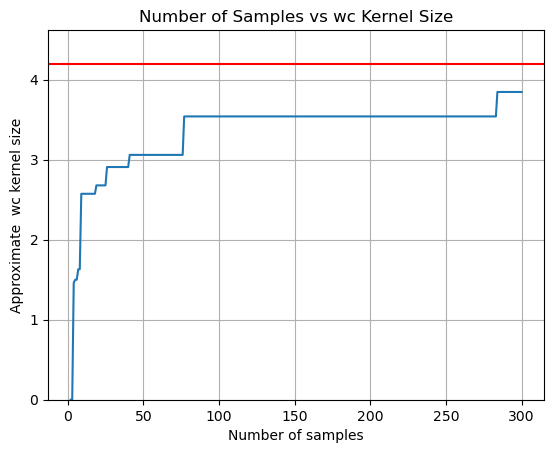

Total Max Kernel Size: 3.8468255967040417
Analytical Kernel Size: 4.2
Relative Error: -0.08408914364189488


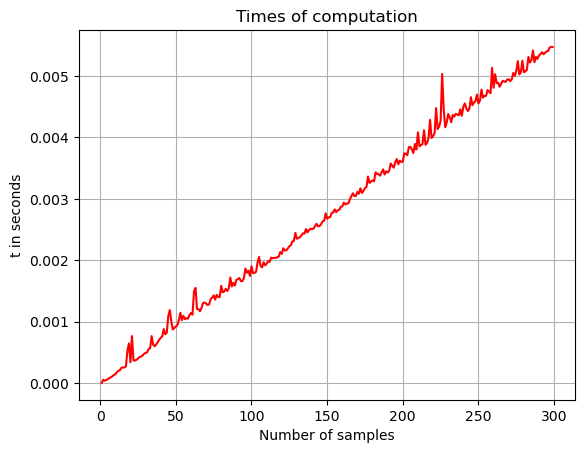

The last kernel size computation took 0.005472 seconds


In [3]:
# Step 2: Compute worst-case kernel sizes:
worstcase_kersize = worstcase_kernelsize(feasible_sets_list, p_1, p)

worstcase_kersize_list = []
times_comput = []
for k in range(0,max_k-1):
    t0 = time.time()
    worstcase_kersize =  worstcase_kernelsize(feasible_sets_list[:k], p_1, p)
    worstcase_kersize_list.append(worstcase_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize, worstcase_kersize_list, wc_kernel_size_analytical, max_k)

plot_times_comput(list(range(1,max_k,1)), times_comput)


### Worst-case kernel size for linear forward model with additive noise, parallelized

In [4]:
batch_size = 50
wc_kersizes = []
times_comput = []
for k in range(1,max_k,1):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=True)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=True)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=True)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=True)    
    distsXX, feasible_appartenance = target_distances_samplingYX_perbatch_cuda(A,  input_loader1, target_loader1, target_loader2,  input_loader2, p_X=2, p_Y=2, epsilon=epsilon)
    t0 = time.time()
    wc_kersize_k = kersize_samplingYX(distsXX, feasible_appartenance)
    t1 = time.time()
    times_comput.append(t1-t0)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, wc_kernel_size_analytical, max_k)

plot_times_comput(list(range(1,max_k,1)), times_comput)




/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 50 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/src/accuracy_bounds/inverseproblems/kersize_compute_dataloader.py:248: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  feasible_appartenance = feasible_appartenance.to_sparse

RuntimeError: Sparse CSR tensors do not have strides

### same but batched

### Average kernel size

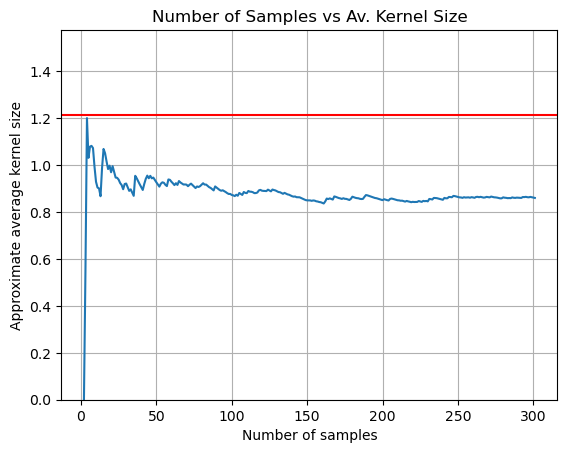

Total Max Kernel Size: 0.8605800402043072
Analytical Kernel Size: 1.2124355652982142
Relative Error: -0.2902055458983204


In [ ]:
# Step 2: Compute average kernel sizes:
average_kersize = average_kernelsize(feasible_sets_list, p_1, p)

average_kersize_list = []
for k in range(0,max_k):
    average_kersize =  average_kernelsize(feasible_sets_list[:k], p_1, p)
    average_kersize_list.append(average_kersize)

plot_avkersize_conv(average_kersize,average_kersize_list, av_kernel_size_analytical, max_k+1)